## Session 4

### Shuffling Transformations / Performance:
- Grouping, Reducing, Joining
- Shuffling, Narrow vs. Wide Dependencies, and Performance Implications
- Exploring the Catalyst Query Optimizer (explain(), Query Plans, Issues with lambdas)
- The Tungsten Optimizer (Binary Format, Cache Awareness, Whole-Stage Code Gen)


##### What is Shuffling in Spark?
- **The Spark SQL shuffle is a mechanism for redistributing or re-partitioning data so that the data is grouped differently across partitions, based on your data size you may need to reduce or increase the number of partitions of RDD/DataFrame using spark.sql.shuffle.partitions configuration or through code.**
##### How to perform shuffling?
- Explore transformations that involve shuffling 
  - Grouping, reducing, joins, etc.
- Understand performance implications of shuffling
- Understand how Catalyst and Tungsten improve performance
  - Be aware of transformations inhibiting their improvements
- We'll use a word count example to drive this session
  - Looking at the various tasks involved, the choices you have, and the implications of each



#### Grouping And Reducing:
- Grouping arranges data into groups
  - Based on values for specified column(s)
  - Generally used for aggregation (e.g. count, max, sum, etc.) 
- Grouping involves shuffling data
  - Redistributing data across partitions
  - Important performance implications 
- DataFrame grouping methods are simple to use 
  - GroupedData handles the aggregation
- RDD groupByKey is more complex
  -Low level, you deal with the (unwieldy) aggregation yourself

### Catalyst and Tungsten: Apache Spark's Speeding Engine
#### What Optimizations does Catalyst Do?
- ##### Predicate Pushdown: Push filtering as early as possible
  - Eliminate data rows not satisfying preconditions early – Projection Pushdown: Project as early as possible
  - Eliminating data columns not needed early
- ##### Reduce shuffling: e.g. by reducing before grouping
  - Or joining in the most efficient manner
- ##### Constant Folding: Fold constant calculations into literals
- ##### Other Optimizations: e.g. convert Decimal ops to long ops

- ##### In the output at bottom
 1. prepares the data
 2. explodes/splits the data
 3. filters the data (note where this is - more on this soon)
 4. project the data
 5. does a partial_count (this is important - more on this soon)
 6. does the shuffling (called an exchange)
 7. does the final counting (an aggregation on word which counts (1))

##### countThenFilterDF.explain() # Filter after counting
== Physical Plan ==
7 *HashAggregate(keys=[word#1168], functions=[count(1)])
6 +- Exchange hashpartitioning(word#1168, 200)
5 +- *HashAggregate(keys=[word#1168], functions=[partial_count(1)])
4 3 2
1
+- *Project [lower(word#1165) AS word#1168] +- *Filter NOT (lower(word#1165) = twinkle)
    +- Generate explode(split(line#852, \s+)), false, false,
                                                    [word#1165]
          +- Scan ExternalRDDScan[obj#849]

#### Tungsten
- Spark uses two engines to optimize and run the queries - Catalyst and Tungsten, in that order. Catalyst basically generates an optimized physical query plan from the logical query plan by applying a series of transformations like predicate pushdown, column pruning, and constant folding on the logical plan. This optimized query plan is then used by Tungsten to generate optimized code, that resembles hand written code, by making use of Whole-stage Codegen functionality introduced in Spark 2.0. This functionality has improved Spark's efficiency by a huge margin from Spark 1.6, which used the traditional Volcano Iterator Model.
- The goal of Project Tungsten is to improve Spark execution by optimising Spark jobs for CPU and memory efficiency (as opposed to network and disk I/O which are considered fast enough). 
- Sharing data from one worker to another can be a costly operation.

#### Whole-Stage Code Generation
- Tungsten optimization to improve execution performance 
  - Collapses a query expression into a single optimized function
- For example suppose we were filtering on the following
   - filter(df.>25 && df.age<50)
   - Code generation dynamically generates bytecode for this • All code contained in one function
   - Instead of classic interpretation
     - With boxing of primitives, polymorphic function calls ...
- Result:
  - Eliminates virtual function calls
  - Leverages CPU registers for intermediate data
  - Can meet/exceed performance of hand-tuned function for a task

#### How Do You Use Tungsten
- Generally, don't think about it much 
  - Just enjoy the benefits
- Operations are performed on data in Tungsten Binary Format 
  - Data is serialized into this format at the very start of the pipeline
     - Generally invisible to clients
  - All succeeding operations work on data in this format
     - Highly memory efficient.
- Most operations use Whole-Stage Code Generation
  - Indicated by an asterisk (*) before the operation name in physical plan 
  - Highly CPU efficient
- Result: Significantly faster execution and reduced memory usage 
   - Huge win for big data workflow
- After scanning, Spark converts data to Tungsten binary format 
  - Generally first thing that's done after reading data in
  - All operations after that are done on this highly efficient format
  - Operations with asterisk (*) use Whole-Stage Code Gen   

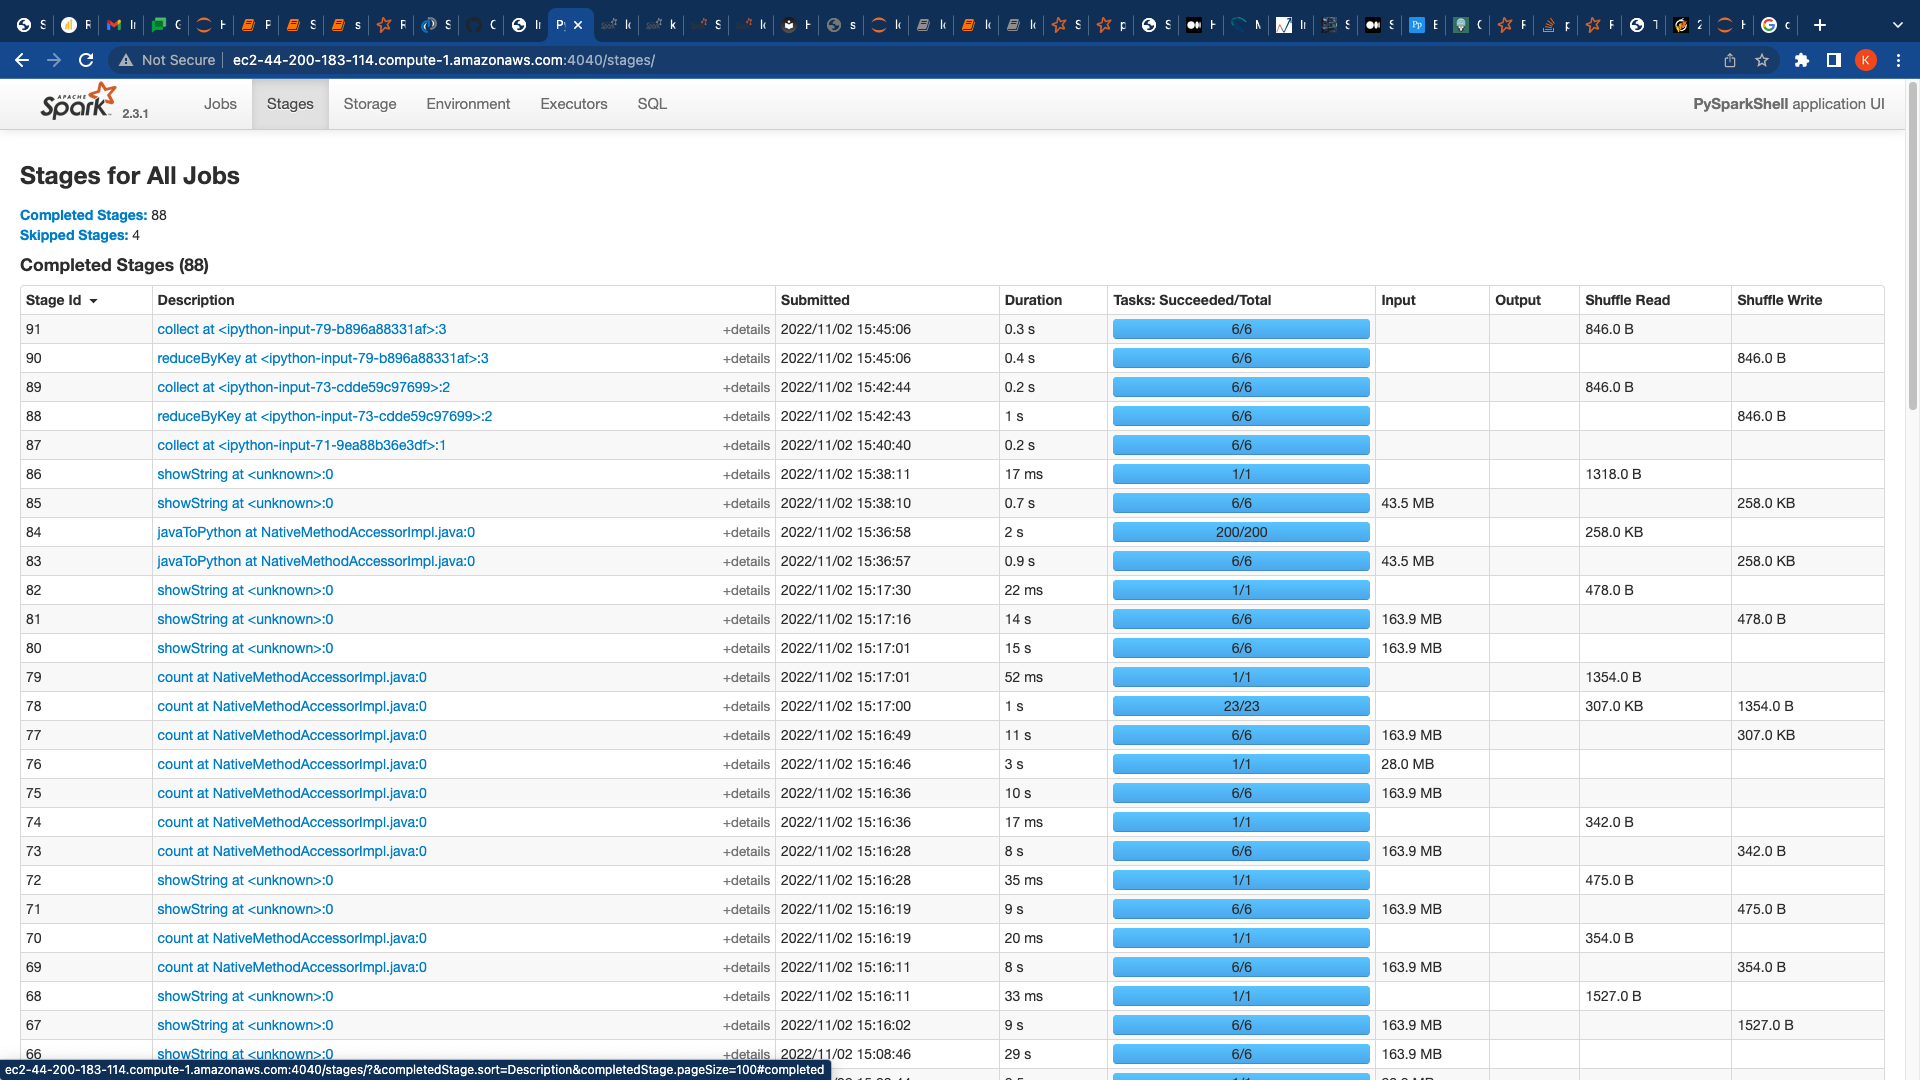

In [1]:
#Build basic spark session
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Demo") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [13]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
df = spark.createDataFrame([([1, 20, 3, 5],), ([1, 20, None, 3],)], ['data'])

In [15]:
my_array_data = [(1, ['A']), (2, ['B','L','B']), (3, ['K','A','K']),(4, ['K']), (3, ['B','P'])]

In [16]:
schema = StructType([StructField("Student_category", IntegerType()),StructField("Student_full_name", ArrayType(StringType()))])
df = spark.createDataFrame(my_array_data, schema=schema)

#### References:
- https://www.projectpro.io/recipes/explain-study-of-spark-query-execution-plans-using-explain
- https://www.clairvoyant.ai/blog/apache-spark-logical-and-physical-plans
- https://www.waitingforcode.com/apache-spark-sql/range-partitioning-apache-spark-sql/read#reparittionByRange